In [1]:
import torch
from PIL import Image
from torch import nn
from torchvision.datasets import MNIST
from torchvision.io import read_image
import torchvision.transforms.functional as fn
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.utils import make_grid
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from custom_neural_network import NeuralNetwork
import os
from os import listdir
from os.path import isfile, join
os.chdir(os.path.abspath(""))

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('model_precise.pt'))
model.eval()
model

NeuralNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=16, out_features=120, bias=True)
    (7): ReLU()
    (8): Linear(in_features=120, out_features=84, bias=True)
    (9): ReLU()
    (10): Linear(in_features=84, out_features=10, bias=True)
    (11): LogSoftmax(dim=1)
  )
)

In [4]:
def cnn_classifier(x):
    return torch.argmax(model(x)).item()

# Test with images created on the fly

In [5]:
with Image.open('Custom test inputs/9e.png') as img:
    test_input = ToTensor()(img)
    if test_input.shape[0] == 4:
        test_input = test_input[None, 3, :, :]
test_input

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [6]:
test_input.shape

torch.Size([1, 96, 96])

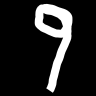

In [7]:
ToPILImage()(test_input)

In [8]:
non_zero = (test_input != 0).nonzero()
h_min = non_zero[:, 1].min()
h_max = non_zero[:, 1].max()
w_min = non_zero[:, 2].min()
w_max = non_zero[:, 2].max()
h_min, h_max, w_min, w_max

(tensor(3), tensor(92), tensor(34), tensor(72))

In [9]:
w_d = w_max - w_min
h_d = h_max - h_min
h_avg = h_min + h_d / 2
w_avg = w_min + w_d / 2
h_tot = test_input.shape[1]
w_tot = test_input.shape[2]
test_input_nn = test_input[:, max(0, int(h_avg-w_d/2)):min(h_tot, int(h_avg+w_d/2)), w_min:w_max] if h_max - h_min < w_max - w_min else test_input[:, h_min:h_max, max(0, int(w_avg-h_d/2)):min(w_tot, int(w_avg+h_d/2))]
test_input_nn

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [10]:
test_input_nn.shape

torch.Size([1, 89, 88])

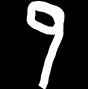

In [11]:
ToPILImage()(test_input_nn)

In [12]:
test_input_nn = fn.resize(test_input_nn, size=[20,20])
ToPILImage()(test_input_nn)

In [13]:
test_input_nn.shape

torch.Size([1, 20, 20])

In [14]:
test_input_nn = fn.pad(test_input_nn, padding=[4,4])
ToPILImage()(test_input_nn)

In [15]:
test_input_nn.shape

torch.Size([1, 28, 28])

In [16]:
print(f"Neural network classification: {cnn_classifier(test_input_nn)}")

Neural network classification: 7


# Classification of all the files in the test folder

In [17]:
def get_test_input_from_pil(img):
    test_input = ToTensor()(img)
    if test_input.shape[0] == 4:
        test_input = test_input[None, 3, :, :]
    non_zero = (test_input != 0).nonzero()
    h_min = non_zero[:, 1].min()
    h_max = non_zero[:, 1].max()
    w_min = non_zero[:, 2].min()
    w_max = non_zero[:, 2].max()
    w_d = w_max - w_min
    h_d = h_max - h_min
    h_avg = h_min + h_d / 2
    w_avg = w_min + w_d / 2
    h_tot = test_input.shape[1]
    w_tot = test_input.shape[2]
    test_input_nn = test_input[:, max(0, int(h_avg-w_d/2)):min(h_tot, int(h_avg+w_d/2)), w_min:w_max] if h_max - h_min < w_max - w_min else test_input[:, h_min:h_max, max(0, int(w_avg-h_d/2)):min(w_tot, int(w_avg+h_d/2))]
    test_input_nn = fn.resize(test_input_nn, size=[20, 20])
    test_input_nn = fn.pad(test_input_nn, padding=[4, 4])
    return test_input_nn

In [18]:
input_dir = 'Custom test inputs'
for f in sorted(listdir(input_dir)):
    if not isfile(join(input_dir, f)):
        continue
    with Image.open(join(input_dir, f)) as img:
        test_input_nn = get_test_input_from_pil(img)
    display(ToPILImage()(test_input_nn))
    print(f"Neural network classification for `{f}`: {cnn_classifier(test_input_nn)}")

Neural network classification for `0.png`: 0


Neural network classification for `0b.png`: 0


Neural network classification for `1.png`: 2


Neural network classification for `1b.png`: 1


Neural network classification for `1c.png`: 7


Neural network classification for `2.png`: 2


Neural network classification for `3.png`: 3


Neural network classification for `4.png`: 7


Neural network classification for `4b.png`: 7


Neural network classification for `4c.png`: 7


Neural network classification for `4d.png`: 7


Neural network classification for `4e.png`: 4


Neural network classification for `5.png`: 3


Neural network classification for `5b.png`: 5


Neural network classification for `6.png`: 6


Neural network classification for `7.png`: 7


Neural network classification for `7b.png`: 3


Neural network classification for `8.png`: 8


Neural network classification for `9.png`: 3


Neural network classification for `9b.png`: 7


Neural network classification for `9c.png`: 7


Neural network classification for `9d.png`: 7


Neural network classification for `9e.png`: 7


Neural network classification for `9f.png`: 9


Neural network classification for `9g.png`: 9


Neural network classification for `user_drawing.png`: 7


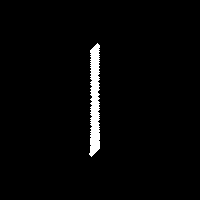

Neural network classification for drawing: 1


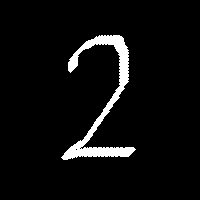

Neural network classification for drawing: 2


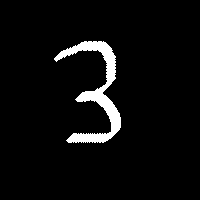

Neural network classification for drawing: 3


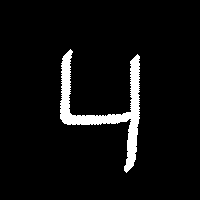

Neural network classification for drawing: 4


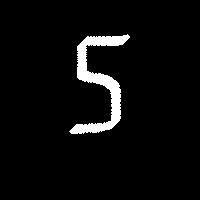

Neural network classification for drawing: 5


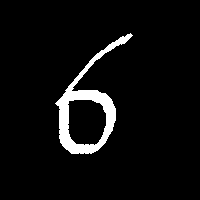

Neural network classification for drawing: 6


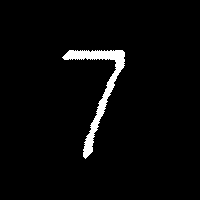

Neural network classification for drawing: 7


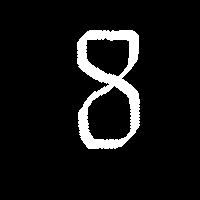

Neural network classification for drawing: 8


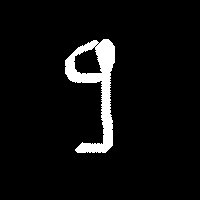

Neural network classification for drawing: 9


In [19]:
from PIL import ImageDraw
import PIL
from tkinter import *

width = 200  # canvas width
height = 200 # canvas height
center = height//2
white = (255, 255, 255) # canvas back

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
    canvas.create_oval(x1, y1, x2, y2, fill='white',width=10)
    draw.line([x1, y1, x2, y2],fill='white',width=10)

master = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(master, width=width, height=height, bg='white')
canvas.pack()

# create an empty PIL image and draw object to draw on
img = PIL.Image.new("1", (width, height))
draw = ImageDraw.Draw(img)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

def clear():
    draw.rectangle((0, 0, width, height), width=0, fill='black')
    canvas.delete('all')

def save():
    filename = "Custom test inputs/user_drawing.png"
    img.save(filename)
    test_input_nn = get_test_input_from_pil(img)
    display(img)
    print(f"Neural network classification for drawing: {cnn_classifier(test_input_nn)}")
    clear()

# add a button to save the image
button=Button(text="save", command=save)
button.pack()

master.mainloop()